# Tratamento de Sinais

ENPE 2020/2
---
* Heitor Pereira de Souza: 744596

* Jhonata Querobim: 727342







# Introdução

## Sinais



---


Um sinal é uma notificação para um processo de que ocorreu um evento. Podem ser descritos como interrupções de software, porque na maioria dos casos, eles interrompem o fluxo normal de execução de um programa e sua chegada é imprevisível. Os sinais podem ser enviados pelo Kernel ou por um processo. A entrega dos sinais é assíncrona.

O Kernel pode enviar um sinal para um processo nas seguintes situações:

* Quando uma exceção de hardware ocorre e essa exceção precisa ser notificada ao processo. Por exemplo. Tentar divisão por zero ou referenciar parte da memória que está inacessível. 
* Algum evento de software ocorreu fora do controle do processo, mas afeta o processo. Por exemplo, a entrada tornou-se disponível em um descritor de arquivo, a janela do terminal foi redimensionada, o limite de tempo da CPU do processo foi excedido, etc. 

* O usuário digitou alguns caractere especiais do terminal, como interrupção (Ctrl + C) ou suspensão (Ctrl + Z).

Os sinais enviados pelo Kernel para notificar os processos sobre os eventos são chamados de sinais tradicionais.

## Sinais Pendentes

---
Depois que um sinal é gerado devido a algum evento, ele não é entregue diretamente a um processo e o sinal permanece em um estado chamado **estado pendente**. Isso é necessário em cenários como:

* O processo não está programado para ter CPU agora. Nesse caso, um sinal pendente é entregue assim que o processo for agendado para execução.

* Para garantir que um sinal não chegue durante a execução de alguma seção crítica, um processo pode adicionar sinal à máscara de sinal de seu processo, que é um conjunto de sinais cuja entrega está atualmente bloqueada. 

* A máscara de sinal do processo é um atributo por processo. Se um sinal for gerado ao ser bloqueado, ele permanecerá no estado pendente até que seja desbloqueado posteriormente. Existem várias chamadas de sistema que permitem a um processo adicionar e remover sinais de sua máscara de sinal.


## Chegada de Sinais



---


Quando um sinal está prestes a ser entregue, uma das seguintes ações padrão ocorre dependendo do sinal:

* O sinal é ignorado, ou seja, é descartado pelo kernel e não tem efeito no processo.

* O processo é encerrado, também conhecido como encerramento anormal do processo, ao contrário do encerramento normal do processo que ocorre quando o programa é encerrado usando exit().

* Um arquivo de dump core é gerado e o processo é encerrado.

* A execução do processo é suspensa ou retomada.


Em vez de aceitar as ações padrão de um sinal específico, um processo pode definir a disposição do sinal alterando a ação que ocorre quando o sinal é entregue. Um programa pode definir uma das seguintes disposições:

* A ação padrão. Isso é útil para desfazer a alteração anterior da 
disposição do sinal para algo diferente do padrão.

* O sinal é ignorado em vez da ação padrão que seria encerrar o processo.

* Um manipulador de sinal estabelecido é executado. Um manipulador de sinal é uma função personalizada que executa tarefas apropriadas em resposta à entrega de um sinal. Notificar o kernel de que uma função de manipulador deve ser invocada quando o sinal chega é conhecido como estabelecimento ou instalação de um manipulador de sinal. Não é possível definir a disposição de um sinal para terminar ou despejar o núcleo, a menos que um deles seja a disposição padrão do sinal.

Os sinais SIGKILL e SIGSTOP não podem ser capturados, bloqueados ou ignorados.

## Envio de Sinais

---
Um sinal pode ser enviado usando a chamada de sistema kill() ou o comando kill via terminal.  

`int kill(pid_t pid, int sig);`

```
SYSCALL_DEFINE2(kill, pid_t, pid, int, sig) {
	struct kernel_siginfo info;

	prepare_kill_siginfo(sig, &info);
	
	return kill_something_info(sig, &info, pid);
 }
```
https://elixir.bootlin.com/linux/v5.4.2/source/kernel/signal.c


Usamos o termo ‘matar’ porque é a ação padrão da maioria dos sinais para encerrar um processo.

O processo pid passado para kill é interpretado de acordo com os seguintes casos:

Se PID> 0, o sinal é enviado a um processo específico com o pid especificado.
* Se PID = 0, então o sinal é enviado para todos os processos no grupo de processos atual.
* Se PID <-1, então o sinal é enviado para todos os processos no grupo de processos atual cujo id do grupo de processos é módulo de PID.
* Se PID = -1, então o sinal é enviado para todos os processos para os quais o processo de chamada tem permissão para enviar um sinal, exceto init e o próprio processo de chamada. Os sinais enviados desta forma são chamados de sinais de transmissão.

Também existe outra função raise() que envia um sinal para o próprio processo de chamada. O sinal é enviado e recebido pelo processo mesmo antes de retornar a função. 

Para implementações com uma única thread, int raise (int sig) é implementado como kill (getpid (), sig).

Para implementações multi thread, int raise (int sig) é implementado como pthread_kill (pthread_self (), sig).

```
static int kill_something_info(int sig, struct kernel_siginfo *info, pid_t pid)
  {
     int ret;
     if (pid > 0) {
        rcu_read_lock();
        ret = kill_pid_info(sig, info, find_vpid(pid));
        rcu_read_unlock();
        return ret;
     }
     /* -INT_MIN is undefined.  Exclude this case to avoid a UBSAN warning */
     if (pid == INT_MIN)
        return -ESRCH;
     read_lock(&tasklist_lock);
     if (pid != -1) {
        ret = __kill_pgrp_info(sig, info, 
           pid ? find_vpid(-pid) : task_pgrp(current));
     } else {
        int retval = 0, count = 0;
        struct task_struct * p;
        for_each_process(p) {
           if (task_pid_vnr(p) > 1 &&
                 !same_thread_group(p, current)) {
              int err = group_send_sig_info(sig, info, p, PIDTYPE_MAX);
              ++count;
              if (err != -EPERM)
                 retval = err;
              }
        }
        ret = count ? retval : -ESRCH;
     }
     read_unlock(&tasklist_lock);
     return ret;
  }
```

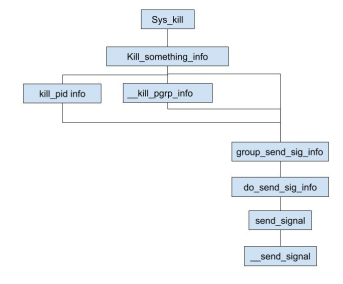

## Tipos de Sinais



---


Existem dois tipos de sinais: **Regular** e **Realtime**.

Os sinais regulares do mesmo tipo não são colocados em fila quando enviados, apenas um sinal de cada tipo é entregue ao processo ou thread. Os sinais do tipo realtime são enfileirados na sequência em que são enviados, independentemente dos tipos já presentes na fila. 

Cada um desses sinais tem uma ação padrão (**default action**), que pode ser:

* Terminate: Mata o processo.
* Coredump: Escreve um arquivo core dump descrevendo o contexto de execução do processo; e então o mata (útil em propósitos de depuração).
* Ignore: O sinal é ignorado, não afeta a execução.
* Stop: Para o processo, isto é, coloca-o no estado TASK_STOPPED.

As ação padrão são descritas em [signal.h](https://elixir.bootlin.com/linux/v5.1.9/source/include/linux/signal.h#L308) e os tipo de sinais também em [signal.h](https://elixir.bootlin.com/linux/v5.1.9/source/arch/x86/include/uapi/asm/signal.h#L103)

A tabela resume os 31 sinais regulares: 

| # |	Nome |	Ação padrão |	Função |
-------------------|------------------|------------------|------------------|
1| 	SIGHUP |	Terminate |	Fecha o terminal ou processo de controle
2| 	SIGINT 	|Terminate 	|Interromper vindo do teclado
3| 	SIGQUIT |	Dump |	Fechar (Quit) vindo do teclado
4| 	SIGILL 	|Dump |	Instrução Ilegal
5| 	SIGTRAP |	Dump 	|Cria um breakpoint para depurar(debugging)
6| 	SIGABRT |	Dump |	Finalização Anormal
6| 	SIGIOT 	|Dump |	Equivalente ao SIGABRT(6)
7| 	SIGBUS |	Dump |	Erro de Barramento
8| 	SIGFPE 	|Dump |	Exceção de Ponto Flutuante
9| 	SIGKILL |	Terminate |	Força o término de um processo
10| 	SIGUSR1 |	Terminate |	Disponível para os processos
11 |	SIGSEGV |	Dump |	Referência a memória inválida
12 	|SIGUSR2 	|Terminate| 	Disponível para os processos
13 	|SIGPIPE 	|Terminate| 	Escreve no pipe sem leitores
14 	|SIGALRM 	|Terminate |	Timer em tempo real (termina quando o timer acaba)
15 	|SIGTERM 	|Terminate |	Termina o processo
16 	|SIGSTKFLT |	Terminate |	Erro na pilha do Coprocessador
17 	|SIGCHLD 	|Ignore |	Processo filho pára, termina ou recebe um sinal, se estiver sendo rastreado
18 	|SIGCONT 	|Ignore|Pára a execução de um processo
20 	|SIGTSTP 	|Stop |	Parada de execução de um processo emitida pelo tty (teclado)
21 	|SIGTTIN 	|Stop |	Um processo em background requisitou entrada (input)
22 	|SIGTTOU 	|Stop |	Um processo em background requisitou saída (output)
23 	|SIGURG 	|Ignore| 	Condição urgente no Socket
24 	|SIGXCPU 	|Dump| 	Limite de tamanho da CPU foi excedido
25 	|SIGXFSZ 	|Dump| 	Limite de tamanho do arquivo foi excedido
26 	|SIGVALARM 	|Terminate| 	Timer virtual
27 	|SIGPROF 	|Terminate| 	Perfil do clock do timer
28 	|SIGWINCH |	Ignore |	Redimensionamento de Janela
29 	|SIGIO 	|Terminate |	I/O disponivel
29 	|SIGPOLL |	Terminate |	Equivalente ao SIGIO(29)
30 	|SIGPWR |	Terminate |	Falha no suprimento de energia
31 	|SIGSYS |	Dump |	Chamada de sistema ruim
31 	|SIGUNUSED |	Dump |	Equivalente ao SIGSYS(31) 

# Estrutura de Dados de Sinais



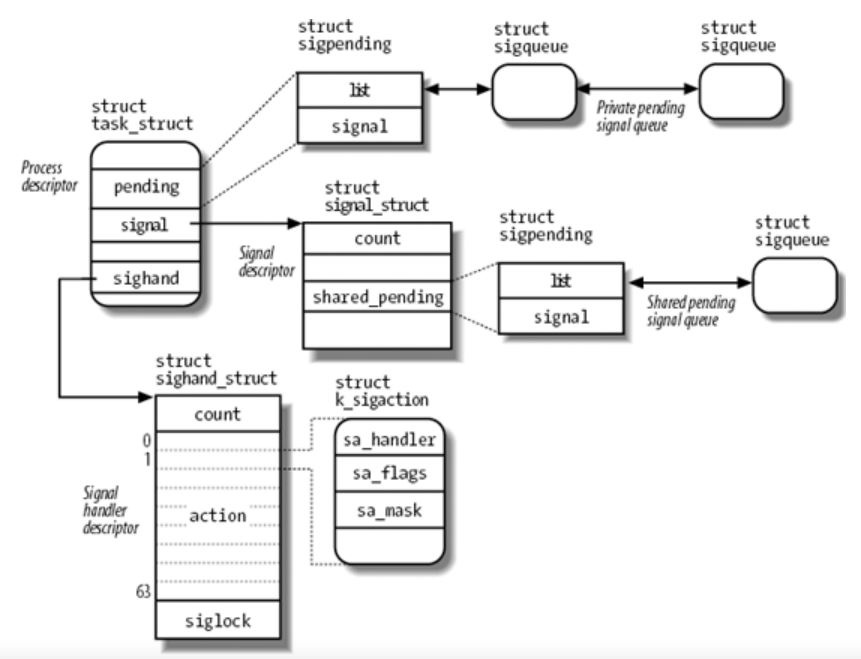

## Descritor de Processos: task_struct

---
*   É uma estrutura do tipo **task_struct** cujos campos contêm todas as informações relacionadas a um único processo.

*   Os campos com informações relacionadas a sinais podem ser acessados em [sched.h](https://elixir.bootlin.com/linux/v5.1.9/source/include/linux/sched.h#L861)

```c
	/* Signal handlers: */
	struct signal_struct		*signal;
	struct sighand_struct		*sighand;
	sigset_t			blocked;
	sigset_t			real_blocked;
	/* Restored if set_restore_sigmask() was used: */
	sigset_t			saved_sigmask;
	struct sigpending		pending;
	unsigned long			sas_ss_sp;
	size_t				sas_ss_size;
	unsigned int			sas_ss_flags;
```

* As variáveis são descritas na tabela abaixo:


Tipo do dado  | Nome da Variável | Descrição          |
-------------------|------------------  |------------------  |
struct signal_struct *       | signal       | Ponteiro para o descritor de sinal do processo              |
struct sighand_struct *   | sighand      |  Ponteiro para o descritor do manipulador de sinal do processo            |
sigset_t   | blocked       |  Máscara de sinais bloqueados            |
sigset_t   | real_blocked       |  Máscara temporária de sinais bloqueados (usada pela chamada de sistema rt_sigtimedwait ())            |
struct sigpending   | pending       |  Estrutura de dados que armazena os sinais privados pendentes            |
unsigned long   | sas_ss_sp       |  Endereço da pilha de manipulador de sinal alternativo            |
size_t   | sas_ss_size       |  Tamanho da pilha de manipulador de sinal alternativo            |
unsigned int |			sas_ss_flags| Flags da pilha alternativa de manipulação de sinal
sigset_t		|	saved_sigmask | Restaurar a máscara de sinal para o retorno de funções que usar outras máscaras







## Representação dos sinais: sigset_t

---
*  Tipo de dados usado para representar um conjunto de 63 sinais

*   Definido em [signal.h](https://elixir.bootlin.com/linux/v5.13-rc7/source/arch/x86/include/asm/signal.h#L23)
```c
 typedef struct {
       unsigned long sig[_NSIG_WORDS];
   } sigset_t;
```
* _NSIG_WORDS é definido em [signal.h](https://elixir.bootlin.com/linux/v5.1.9/source/arch/x86/include/asm/signal.h#L8)

```c
/* Most things should be clean enough to redefine this at will, if care
   is taken to make libc match.  */

#define _NSIG		64
# define _NSIG_BPW	32
#define _NSIG_WORDS	(_NSIG / _NSIG_BPW)
```

* Daí, Temos **_NSIG_WORDS** = 2 X 32 bits **unsigned long** = 64 bits para representar os sinais, não existe o sinal 0, dessa forma restarm 63 sinais.

* De 32 a 63 tem-se os sinais de tempo real (**realtime signals**), podem ser enfileirados. Mantidos em sig[1]

* De 1 a 31 tem-se os sinais tradicionais abordados na introdução, mantidos em sig[0]

* Em task_struct temos sigset_t blocked e real_blocked

* **sigset_t blocked** trata-se das máscara de sinais bloqueados.

* **sigset_t real_blocked** trata-se da máscara temporária de sinais bloqueados, usada pela syscall rt_sigtimedwait. A thread espera um sinal por um determinado período de tempo. A máscara temporária é necessária pois a máscara real (blocked) pode ter sido alterada.

* **sigsrt_t saved_sigmask**: Algumas chamadas de sistema precisam mudar a máscara de sinal durante a operação, e os manipuladores de sinal devem ser chamados usando a nova máscara de sinal temporária. A máscara de sinal antiga deve ser restaurada após a saída bem-sucedida da chamada do sistema ou ao retornar do manipulador de sinais chamado, se a chamada do sistema for interrompida. Não podemos simplesmente restaurar a máscara de sinal original e retornar ao userspace, já que a máscara de sinal restaurada pode realmente bloquear o sinal que interrompeu a chamada do sistema.



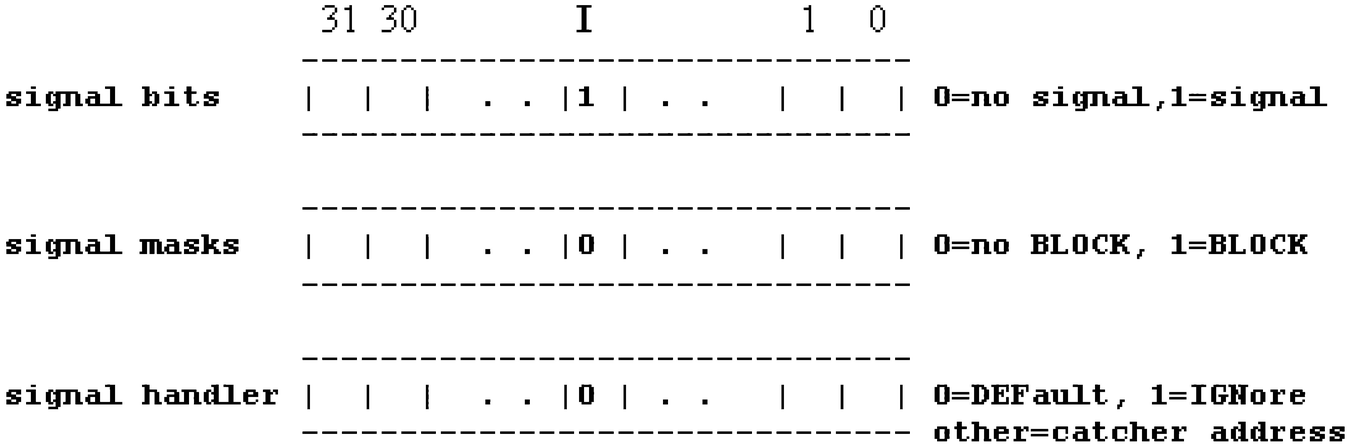

## Descritor de Sinais: signal_struct

---

* O campo sinal do descritor de processo aponta para um descritor de sinal, uma estrutura **signal_struct** responsável por controlar os sinais pendentes compartilhados
* Inclui campos não  relacionados ao tratamento de sinais
* Compartilhado por todos os processos do mesmo grupo de threads
* A estrutura signal_struct é definida em [signal.h](https://elixir.bootlin.com/linux/v5.13-rc6/source/include/linux/sched/signal.h#L82)

*   As variáveis são descritas na tabela abaixo:

Tipo do dado  | Nome da variável | Descrição          |
-------------------|------------------  |------------------  |
atomic_t | 	count | Contador |
atomic_t | live |  Número de threads ativas
struct task_struct * | curr_target | Descritor do processo mais recente no grupo de threads que recebeu um sinal |
struct sigpending | shared_pending | Estrutura de dados que armazena os sinais pendentes compartilhados |
int | group_exit_code | Código de encerramento do processo para grupo de threads
struct task_struct * | group_exit_task | Usado ao matar um grupo de threads 
int | notify_count | Usado ao matar um grupo de threads 
int | group_stop_count | Usado ao interromper um grupo de threads 
unsigned int | flags | Flags relacionadas  a entrega de sinais que modificam status do processo |







## Descritor de Tratador de Sinais: sighand_struct

---
* O campo signal do descritor de processo aponta para um descritor de tratador de sinal, uma estrutura sighand_struct responsável por controlar como cada sinal deve ser tratado pelo grupo de threads

* A estrutura **sighand_struct** é definida em [signal.h](https://elixir.bootlin.com/linux/v5.13-rc6/source/include/linux/sched/signal.h#L20)

* As variáveis são descritas na tabela abaixo:

Tipo do dado  | Nome da variável | Descrição          |
-------------------|------------------  |------------------  |
refcount_t	|	count |	Contador: Número de processos que compartilham a estrutural |
struct k_sigaction [_NSIG	] |	action | 	Vetor de estruturas especificando as ações durante a entrega de sinais
spinlock_t		|siglock| Spin lock para proteção , trava a thread

* OBS: _NSIG = Número de Sinais = 64

* Vetor de 63 sinais, indicando qual a ação respectiva associada a esse sinal

## Lista de Sinais Pendentes: sigpending




---



Para acompanhar os sinais pendentes o kernel possui dois tipos de filas para cada process, uma privada e uma compartilhada:

* A fila de sinais pendentes compartilhados, tem a sua raiz no campo shared_pending do descritor de sinal, armazena os sinais pendentes de todo o grupo de threads.

* A fila de sinais pendentes privada, tem a sua raiz no campo pending do descritor de processo, armazena os sinais pendentes do processo específico.

A fila de sinais pendentes é caracterizada por uma estrutura sigpending definida em [signal_types.h](https://elixir.bootlin.com/linux/v5.13-rc6/source/include/linux/signal_types.h#L30)

```c
  struct sigpending {
        struct list_head list;
        sigset_t signal;
    }
```



*   **signal** é a mascára de sinais pendentes
*   **list** é uma lista encadeada dupla do tipo **sigqueue**, importante para lidar com os sinais de tempo real


* sigqueue é definida em [signal_types.h](https://elixir.bootlin.com/linux/v5.4.2/source/include/linux/signal_types.h#L20)

```c
  /*
  * Real Time signals may be queued.
  */
  struct sigqueue {
     struct list_head list;
     int flags;             
     kernel_siginfo_t info; // Evento que gerou o sinal
     struct user_struct *user; // Dono do processo
  };
```







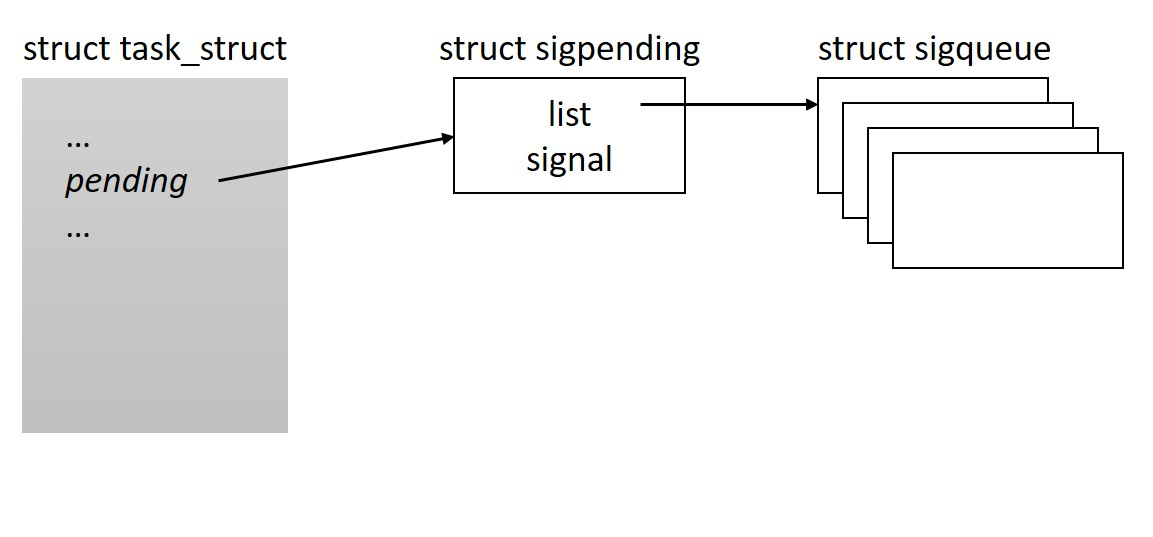

## A estrutura sigaction: k_sigaction

---
* A estrutura **k_sigaction** é definida em [signal_types.h](https://elixir.bootlin.com/linux/v5.13-rc6/source/include/linux/signal_types.h#L49)

*  Contém propriedades de sinais que visíveis apenas ao kernel, bem como aquelas visíveis em modo de usuário. 

* Entre as de modo usuário há à estrutura **sigaction** definida em [signal_types.h](https://elixir.bootlin.com/linux/v5.13-rc6/source/include/linux/signal_types.h#L35)

* As variáveis são descritas na tabela abaixo:

Tipo do dado  | Nome da variável | Descrição          |
-------------------|------------------  |------------------  |
__sighandler_t		|	sa_handler |	Ação a ser realizada: Ação padrão (SIG_DFL, valor 0) ou sinal ignorada (SIG_IGN, valor 1). |
unsigned long |	sa_flags | 	Como o sinal deve ser tratado
sigset_t | sa_mask | Quais os sinais a serem mascarados ao executar o tratador de sinais. |

* Em [signal.h](https://elixir.bootlin.com/linux/v5.1.9/source/arch/x86/include/uapi/asm/signal.h#L78) encontra-se algumas das flags de sigaction:

Flag  | Descrição |
-------------------|------------------  |
SA_NOCLDSTOP | Apenas para SIGCHLD; não envia SIGCHLD para o pai quando o processo for interrompido |
SA_NOCLDWAIT | Apenas SIGCHLD; não crie um zumbi quando o processo terminar
SA_SIGINFO | Informações adicionais ao tratador de sinal 
SA_ONSTACK | Usa  pilha alternativa para o tratador de sinal 
SA_RESTART | As chamadas do sistema interrompidas são reiniciadas automaticamente |
SA_NODEFER, SA_NOMASK | Não mascare o sinal enquanto executa o tratador de sinal
SA_RESETHAND, SA_ONESHOT | Redefinir para a ação padrão após executar o tratador de sinal




# Geração de Sinais

---

No Linux, é possível enviar sinais de várias formas:

* Enviar para uma thread
* Enviar para um processo (thread group)

Para tal, existem funções com declarações específicas e syscalls definidas.


## Envio a uma Thread

Quando um sinal é enviado a uma thread, o kernel gera esses sinais invocando uma das seguintes funções definidas em [ signal.c (source/kernel/signal.c).](https://elixir.bootlin.com/linux/v5.1.9/source/kernel/signal.c#L1549) 

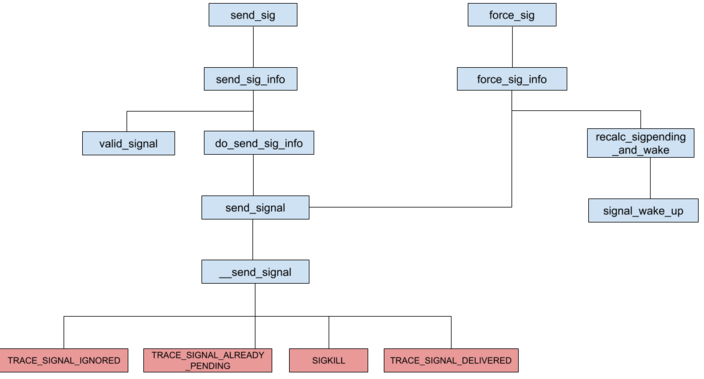

### send_sig

A função **send_sig** envia um sinal (**sig**) para uma única thread (*p) com identificação do tipo de sinal (priv): 

```
  int send_sig(int sig, struct task_struct *p, int priv)
  {
     return send_sig_info(sig, __si_special(priv), p);
  }
```

Então chama a função **send_sig_info**, que esta verifica **priv** através da função **__si_special**, determinando se **priv** é **SEND_SIG_NOINFO** ou **SEND_SIG_PRIV**. A primeira significa é enviado pelo usuário e o segundo, pelo kernel. 

```
  int send_sig_info(int sig, struct kernel_siginfo *info, struct task_struct *p)
  {
     if (!valid_signal(sig))
        return -EINVAL;
     return do_send_sig_info(sig, info, p, PIDTYPE_PID);
  }
```

A função **send_sig_info** verifica se o sinal é válido (sig <= _NSIG ? 1 : 0) e em caso afirmativo, chama **do_send_sig_info**: 

```
  int do_send_sig_info(int sig, struct kernel_siginfo *info, struct task_struct *p, enum pid_type type)
  {
     unsigned long flags;
     int ret = -ESRCH;
     if (lock_task_sighand(p, &flags)) {
        ret = send_signal(sig, info, p, type);
        unlock_task_sighand(p, &flags);
     }
     return ret;
  }
```

É utilizado um lock para não haver conflito de acesso. Então, finalmente, chama a função **send_signal**: 

```
  static int send_signal(int sig, struct kernel_siginfo *info, struct task_struct *t, enum pid_type type)
  {
     int from_ancestor_ns = 0;
     #ifdef CONFIG_PID_NS
        from_ancestor_ns = si_fromuser(info) && !task_pid_nr_ns(current, task_active_pid_ns(t));
     #endif
     return __send_signal(sig, info, t, type, from_ancestor_ns);
  }
```

A função **__send_signal** fará algumas tratativas:

* Verifica se o sinal deve ser ignorado (**TRACE_SIGNAL_IGNORED**);
* Verifica se o sinal já está no sigqueue (**TRACE_SIGNAL_ALREADY_PENDING**);
* Ignora a alocação **siginfo** inútil para em caso de **SIGKILL**;
* Adiciona o sinal na lista de pendings com list_add_tail (**TRACE_SIGNAL_DELIVERED**) e ativa **TIF_SIGPENDING**;

```
static int __send_signal(int sig, struct kernel_siginfo *info, struct task_struct *t,
			enum pid_type type, int from_ancestor_ns)
{
	struct sigpending *pending;
	struct sigqueue *q;
	int override_rlimit;
	int ret = 0, result;

	assert_spin_locked(&t->sighand->siglock);

	result = TRACE_SIGNAL_IGNORED;
	if (!prepare_signal(sig, t,
			from_ancestor_ns || (info == SEND_SIG_PRIV)))
		goto ret;

	pending = (type != PIDTYPE_PID) ? &t->signal->shared_pending : &t->pending;
	/*
	 * Short-circuit ignored signals and support queuing
	 * exactly one non-rt signal, so that we can get more
	 * detailed information about the cause of the signal.
	 */
	result = TRACE_SIGNAL_ALREADY_PENDING;
	if (legacy_queue(pending, sig))
		goto ret;

	result = TRACE_SIGNAL_DELIVERED;
	/*
	 * Skip useless siginfo allocation for SIGKILL and kernel threads.
	 */
	if ((sig == SIGKILL) || (t->flags & PF_KTHREAD))
		goto out_set;

	/*
	 * Real-time signals must be queued if sent by sigqueue, or
	 * some other real-time mechanism.  It is implementation
	 * defined whether kill() does so.  We attempt to do so, on
	 * the principle of least surprise, but since kill is not
	 * allowed to fail with EAGAIN when low on memory we just
	 * make sure at least one signal gets delivered and don't
	 * pass on the info struct.
	 */
	if (sig < SIGRTMIN)
		override_rlimit = (is_si_special(info) || info->si_code >= 0);
	else
		override_rlimit = 0;

	q = __sigqueue_alloc(sig, t, GFP_ATOMIC, override_rlimit);
	if (q) {
		list_add_tail(&q->list, &pending->list);
		switch ((unsigned long) info) {
		case (unsigned long) SEND_SIG_NOINFO:
			clear_siginfo(&q->info);
			q->info.si_signo = sig;
			q->info.si_errno = 0;
			q->info.si_code = SI_USER;
			q->info.si_pid = task_tgid_nr_ns(current,
							task_active_pid_ns(t));
			q->info.si_uid = from_kuid_munged(current_user_ns(), current_uid());
			break;
		case (unsigned long) SEND_SIG_PRIV:
			clear_siginfo(&q->info);
			q->info.si_signo = sig;
			q->info.si_errno = 0;
			q->info.si_code = SI_KERNEL;
			q->info.si_pid = 0;
			q->info.si_uid = 0;
			break;
		default:
			copy_siginfo(&q->info, info);
			if (from_ancestor_ns)
				q->info.si_pid = 0;
			break;
		}

		userns_fixup_signal_uid(&q->info, t);

	} else if (!is_si_special(info)) {
		if (sig >= SIGRTMIN && info->si_code != SI_USER) {
			/*
			 * Queue overflow, abort.  We may abort if the
			 * signal was rt and sent by user using something
			 * other than kill().
			 */
			result = TRACE_SIGNAL_OVERFLOW_FAIL;
			ret = -EAGAIN;
			goto ret;
		} else {
			/*
			 * This is a silent loss of information.  We still
			 * send the signal, but the *info bits are lost.
			 */
			result = TRACE_SIGNAL_LOSE_INFO;
		}
	}

out_set:
	signalfd_notify(t, sig);
	sigaddset(&pending->signal, sig);

	/* Let multiprocess signals appear after on-going forks */
	if (type > PIDTYPE_TGID) {
		struct multiprocess_signals *delayed;
		hlist_for_each_entry(delayed, &t->signal->multiprocess, node) {
			sigset_t *signal = &delayed->signal;
			/* Can't queue both a stop and a continue signal */
			if (sig == SIGCONT)
				sigdelsetmask(signal, SIG_KERNEL_STOP_MASK);
			else if (sig_kernel_stop(sig))
				sigdelset(signal, SIGCONT);
			sigaddset(signal, sig);
		}
	}

	complete_signal(sig, t, type);
ret:
	trace_signal_generate(sig, info, t, type != PIDTYPE_PID, result);
	return ret;
}
```

### force_sig

A função **force_sig** envia um sinal (**sig**) para uma thread (**p**) que não pode ser explicitamente ignorado ou bloqueado pelo processo. 

```
  void force_sig(int sig, struct task_struct *p)
  {
     force_sig_info(sig, SEND_SIG_PRIV, p);
  }
```

Ela chama a função **force_sig_info**, que um sinal que a thread não pode ignorar. Se necessário, desbloqueia o sinal e muda qualquer **SIG_IGN** para **SIG_DFL**. Se desbloquear o sinal, deve ser sempre redefinido para **SIG_DFL**, já que não é esperado que um manipulador de sinal que foi bloqueado seja invocado quando o espaço do usuário o bloqueia explicitamente.

```
int
force_sig_info(int sig, struct kernel_siginfo *info, struct task_struct *t)
{
	unsigned long int flags;
	int ret, blocked, ignored;
	struct k_sigaction *action;

	spin_lock_irqsave(&t->sighand->siglock, flags);
	action = &t->sighand->action[sig-1];
	ignored = action->sa.sa_handler == SIG_IGN;
	blocked = sigismember(&t->blocked, sig);
	if (blocked || ignored) {
		action->sa.sa_handler = SIG_DFL;
		if (blocked) {
			sigdelset(&t->blocked, sig);
			recalc_sigpending_and_wake(t);
		}
	}
	/*
	 * Don't clear SIGNAL_UNKILLABLE for traced tasks, users won't expect
	 * debugging to leave init killable.
	 */
	if (action->sa.sa_handler == SIG_DFL && !t->ptrace)
		t->signal->flags &= ~SIGNAL_UNKILLABLE;
	ret = send_signal(sig, info, t, PIDTYPE_PID);
	spin_unlock_irqrestore(&t->sighand->siglock, flags);

	return ret;
}
```

## Envio a um Processo

Quando um sinal é enviado a um processo (thread group), seja pelo kernel, ou por um processo, o kernel gera este sinal invocando uma das seguintes funções: 

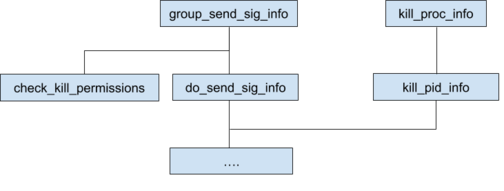

### group_send_sig_info

A função **group_send_sig_info** envia um sinal para um unico processo identificado pelo descritor de processos de um de seus membros (threads). 

```
  int group_send_sig_info(int sig, struct kernel_siginfo *info, struct task_struct *p, enum pid_type type)
  {
     int ret;
     rcu_read_lock();
     ret = check_kill_permission(sig, info, p);
     rcu_read_unlock();
     if (!ret && sig)
        ret = do_send_sig_info(sig, info, p, type);
     return ret;
  }
```

Ela bloqueia a leitura e checa se o sinal passado é válido, caso seja, chama a função **do_send_sig_info**, caso não seja, a função **check_kill_permission** retorna **EINVAL**, que indica que o sinal passado é inválido. 

```
  int do_send_sig_info(int sig, struct kernel_siginfo *info, struct task_struct *p, enum pid_type type)
  {
     unsigned long flags;
     int ret = -ESRCH;
     if (lock_task_sighand(p, &flags)) {
        ret = send_signal(sig, info, p, type);
        unlock_task_sighand(p, &flags);
      }
     return ret;
  }
```

### kill_pgrp

A função **kill_pgrp** é uma função que envia um sinal para todos as threads de um processo. 

```
  int kill_pgrp(struct pid *pid, int sig, int priv)
  {
     int ret;
     read_lock(&tasklist_lock);
     ret = __kill_pgrp_info(sig, __si_special(priv), pid);
     read_unlock(&tasklist_lock);
     return ret;
  }
```

Essa função bloqueia a leitura, para que possa ser chamada a função **__kill_pgrp_info**: 

```
  int __kill_pgrp_info(int sig, struct kernel_siginfo *info, struct pid *pgrp)
  {
     struct task_struct *p = NULL;
     int retval, success;
     success = 0;
     retval = -ESRCH;
     do_each_pid_task(pgrp, PIDTYPE_PGID, p) {
        int err = group_send_sig_info(sig, info, p, PIDTYPE_PGID);
        success |= !err;
        retval = err;
      } while_each_pid_task(pgrp, PIDTYPE_PGID, p);
      return success ? 0 : retval;
  }
```

A função **__kill_pgrp_info** verifica se o processo existe, se sim, chama a função **group_send_sig_info** passando o sinal e retornando se a operação foi bem sucedida. Caso o processo não exista, retorna **-ESRCH**, que indica que não existe o processo. 

### kill_proc_info

A função **kill_proc_inf**o envia um sinal para um único processo, identificado pelo PID. 

```
  static int kill_proc_info(int sig, struct kernel_siginfo *info, pid_t pid)
  {
     int error;
     rcu_read_lock();
     error = kill_pid_info(sig, info, find_vpid(pid));
     rcu_read_unlock();
     return error;
  }
```

Essa função bloqueia a leitura e chama a função **kill_pid_info**: 

```
  int kill_pid_info(int sig, struct kernel_siginfo *info, struct pid *pid)
  {
     int error = -ESRCH;
     struct task_struct *p;
     for (;;) {
        rcu_read_lock();
        p = pid_task(pid, PIDTYPE_PID);
        if (p)
           error = group_send_sig_info(sig, info, p, PIDTYPE_TGID);
        rcu_read_unlock();
        if (likely(!p || error != -ESRCH))
           return error;
     }
  }
```

A função **kill_pid_info** verifica se o pid indicado é valido, e então chama a função **group_send_sig_info** até obter sucesso. Caso o pid não seja valido, retorna **ESRCH**, que indica que o processo não existe. 

## Envio do SIGCHLD

Pode ser necessário enviar o **SIGCHLD** para processos bloqueados com **wait** e **waitpid**.

Isso pode ser feito pela função **do_notify_parent**, definida em [signal.c (source/kernel/signal.c).](https://elixir.bootlin.com/linux/v5.1.6/source/kernel/signal.c#L1826)

```
  do_notify_parent(struct task_struct *tsk, int sig)
```

Ela avisa o pai sobre a morte de um filho. Para uma mudança de status stopped/continued, usa o **do_notify_parent_cldstop**. O parâmetro **tsk** é a task que está mudando de estado; **for_ptracer** indica se a notificação é para um **ptracer** ou não; **why** indica o motivo do aviso (CONTINUED|STOPPED|TRAPPED). 

```
  static void do_notify_parent_cldstop(struct task_struct *tsk, bool for_ptracer, int why)
```

Elas podem ser chamadas em funções do [exit.c (source/kernel/exit.c)](https://elixir.bootlin.com/linux/v5.1.9/source/kernel/exit.c#L216), como **release_task**, **reparent_leader**, **exit_notify** e **wait_task_zombie**. Ainda, podem ser chamadas na função **__ptrace_detach** do [ptrace.c (source/kernel/ptrace.c).](https://elixir.bootlin.com/linux/v5.1.9/source/kernel/ptrace.c#L518)

# Entrega de Sinais

---

## Estrutura Geral


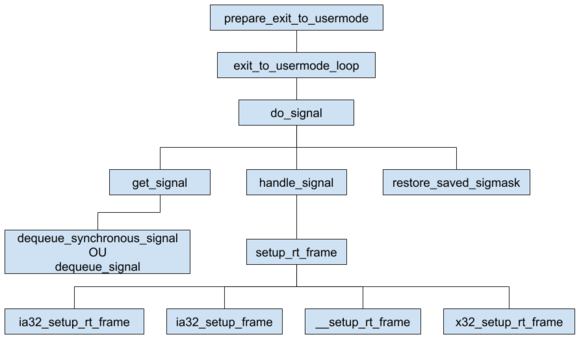

Quando um sinal é enviado para um processo, seu tratamento ocorre apenas quando aquele processo tiver seu contexto restaurado na CPU. Quando isto ocorrer, assumimos que o SO percebeu a chegada de um sinal e realizou as chamadas de funções necessárias para configurar o task_struct do processo ou thread que deve receber o sinal para que o sinal seja tratado na troca de contexto.

Quando o contexto de um processo ou thread estiver para ser restaurado na CPU, a função **prepare_exit_to_usermode** é chamada, nesta função ocorre a verificação de flags do processo ou thread para ver se o mesmo está apto a retornar para o userspace. Entre as flags checadas, é verificado a flag **_TIF_SIGPENDING** através da macro **EXIT_TO_USERMODE_LOOP_FLAGS**, que indica se há um sinal pendente para o processo ou flag. Caso alguma das flags esteja ativa, a função **exit_to_usermode_loop** é chamada para tratar as diversas flags checadas anteriormente. Esses tratamentos são feitos em um loop até que todas as flags tenham sido tratadas, entre elas todos os sinais pendentes. 

```
__visible inline void prepare_exit_to_usermode(struct pt_regs *regs){
     struct thread_info *ti = current_thread_info();
     u32 cached_flags;
     ...
     cached_flags = READ_ONCE(ti->flags);
     //Checa se há alguma flag ativa de EXIT_TO_USERMODE_LOOP_FLAGS em cached_flags
     if (unlikely(cached_flags & EXIT_TO_USERMODE_LOOP_FLAGS))
         exit_to_usermode_loop(regs, cached_flags);
  }
```

Dentro da função **exit_to_usermode_loop**, a flag **_TIF_SIGPENDING** é checada novamente, dessa vez individualmente e se a mesma estiver ativa a função **do_signal** é chamada para tratar um dos sinais que estiverem na fila de sinais pendentes. Esta função busca por um sinal pendente na fila utilizando a função **get_signal** e então trata este sinal utilizando a função **handle_signal**. Este processo é repetido até que a flag **_TIF_SIGPENDING** esteja desativada, indicando que todos os sinais pendentes foram tratados. 

```
  static void exit_to_usermode_loop(struct pt_regs *regs, u32 cached_flags){
     while (true) {
         ...
         /* deal with pending signal delivery */
         //Checa se a flag _TIF_SIGPENDING está ativa em cached_flags
         if (cached_flags & _TIF_SIGPENDING)
             do_signal(regs);
         ...
         //Se nenhuma flag de EXIT_TO_USERMODE_LOOP_FLAGS estiver ativa sai do loop
         if (!(cached_flags & EXIT_TO_USERMODE_LOOP_FLAGS))
             break;
     }
  }
```

```
  void do_signal(struct pt_regs *regs){
     struct ksignal ksig;
     if (get_signal(&ksig)) {
         /* Whee! Actually deliver the signal.  */
         handle_signal(&ksig, regs);
         return;
     }
     
     /* Did we come from a system call? */
     if (syscall_get_nr(current, regs) >= 0) {
         /* Restart the system call - no handlers present */
         switch (syscall_get_error(current, regs)) {
         case -ERESTARTNOHAND:
         case -ERESTARTSYS:
         case -ERESTARTNOINTR:
            regs->ax = regs->orig_ax;
            regs->ip -= 2;
            break;
         case -ERESTART_RESTARTBLOCK:
            regs->ax = get_nr_restart_syscall(regs);
            regs->ip -= 2;
            break;
         }
     }
     restore_saved_sigmask();
  }
```

## Recuperando o próximo sinal a ser tratado

Dentro da função **get_signal** diversas ações são realizadas, porém as mais relevantes para a entrega de sinais são:

* Retira um dos sinais pendentes da fila através das funções que retiram um sinal da fila de sinais pendentes **dequeue_synchronous_signal** ou **dequeue_signal**. Caso nenhuma dessas funções retorne um sinal, a função retorna o valor 0, indicando que não existem mais sinais não bloqueantes na fila de sinais pendentes e que o loop da função **exit_to_usermode_loop** pode sair do loop e finalizar.
    
  * As funções de **dequeue** consideram sempre os sinais de menor valor primeiramente. Além disso os sinais privados, enviados apenas para aquele processo ou thread específico, são considerados antes dos sinais compartilhados. Por fim, a função atualiza as estruturas de dados para indicar que o sinal não está mais pendente e retorna seu número para a função **get_signal**. Esta tarefa envolve limpar o bit correspondente em **current->pending.signal**, para sinais privados, ou **current->signal->shared_pending.signal**, para sinais compartilhados, e chamar **recalc_sigpending** para atualizar o valor do sinalizador **_TIF_SIGPENDING**.

* Com o número do sinal obtido, a função de tratamento relacionada ao sinal recuperado é guardada em uma variável nomeada **k_sigaction ka**, como mostra o código abaixo. Dependendo do contexto 3 tipos de ações podem ser realizadas a partir desta função de tratamento: ignorar o sinal, executar a ação padrão da função de tratamento ou executar a função de tratamento definida pelo usuário para aquele sinal.

  * Em caso de uma função definida pelo usuário, é também verificado se a flag **SA_ONESHOT** está ativa. Esta flag indica que a função de tratamento padrão deve ser retornada para a função padrão para que futuras ocorrências do mesmo sinal não ativem novamente a execução do signal handler. Assim o handler do sinal é definido como como **SIG_DFL**.

```
bool get_signal(struct ksignal *ksig){
     struct sighand_struct *sighand = current->sighand;
     struct signal_struct *signal = current->signal;
     int signr;
     …
     for (;;) {
         struct k_sigaction *ka;
         signr = dequeue_synchronous_signal(&ksig->info);
         if (!signr)
             signr = dequeue_signal(current, &current->blocked, &ksig->info);
         if (!signr) //nenhum sinal foi encontrado pendente
             break; /* will return 0 */
         //Recupera o a funcao de tratamento do sinal recuperado
         ka = &sighand->action[signr-1];
         ...
         if (ka->sa.sa_handler == SIG_IGN) /* Do nothing.  */
             continue;
         if (ka->sa.sa_handler != SIG_DFL) {
             /* Run the handler.  */
             ksig->ka = *ka;
             if (ka->sa.sa_flags & SA_ONESHOT)
                 ka->sa.sa_handler = SIG_DFL;
             break; /* will return non-zero "signr" value */
         }
     }
  }
```

## Realizando a Ação Default

Ainda dentro da função **get_signal** são realizadas as ações default dos sinais, realizando as seguintes ações:

* É checado se o handler padrão ignora o sinal e então o ignora se for o caso;
* É checado se o sinal foi enviado ao processo init ou ao container-init, que podem ignorar qualquer sinal;
* É checado se o sinal é algum tipo de sinal de parada, chamando a função **do_signal_stop** para parar os processos;
* Se nenhuma das checagens acima for realizada a função default é um **dump** ou **kill**, desse modo sendo fatal para o processo. O dump ocorre com a chamada da função **sig_kernel_coredump** e o kill com a chamada de **do_group_exit**.

Por fim, se o sinal for capturado e tiver um novo handler especificado, este precisa ser realizado e então a função retorna True para que a função **handle_signal** seja chamada. 

```
bool get_signal(struct ksignal *ksig){
     ...
     /*
     * Now we are doing the default action for this signal.
     */
     if (sig_kernel_ignore(signr)) /* Default is nothing. */
        continue;
     /*
     * Global init gets no signals it doesn't want.
     * Container-init gets no signals it doesn't want from same
     * container.
     *
     * Note that if global/container-init sees a sig_kernel_only()
     * signal here, the signal must have been generated internally
     * or must have come from an ancestor namespace. In either
     * case, the signal cannot be dropped.
     */
     if (unlikely(signal->flags & SIGNAL_UNKILLABLE) && !sig_kernel_only(signr))
        continue;
     if (sig_kernel_stop(signr)) {
     /*
     * The default action is to stop all threads in
     * the thread group.  The job control signals
     * do nothing in an orphaned pgrp, but SIGSTOP
     * always works.  Note that siglock needs to be
     * dropped during the call to is_orphaned_pgrp()
     * because of lock ordering with tasklist_lock.
     * This allows an intervening SIGCONT to be posted.
     * We need to check for that and bail out if necessary.
     */
     if (signr != SIGSTOP) {
        spin_unlock_irq(&sighand->siglock);
        /* signals can be posted during this window */
        if (is_current_pgrp_orphaned())
           goto relock;
        spin_lock_irq(&sighand->siglock);
     }
     if (likely(do_signal_stop(ksig->info.si_signo))) {
        /* It released the siglock.  */
        goto relock;
     }
     /*
     * We didn't actually stop, due to a race
     * with SIGCONT or something like that.
     */
     continue;
     }
     fatal:
     spin_unlock_irq(&sighand->siglock);
     /*
     * Anything else is fatal, maybe with a core dump.
     */
     current->flags |= PF_SIGNALED;
     if (sig_kernel_coredump(signr)) {
        if (print_fatal_signals)
           print_fatal_signal(ksig->info.si_signo);
        proc_coredump_connector(current);
        /*
        * If it was able to dump core, this kills all
        * other threads in the group and synchronizes with
        * their demise.  If we lost the race with another
        * thread getting here, it set group_exit_code
        * first and our do_group_exit call below will use
        * that value and ignore the one we pass it.
        */
        do_coredump(&ksig->info);
     }
     /*
     * Death signals, no core dump.
     */
     do_group_exit(ksig->info.si_signo);
     /* NOTREACHED */
     }
     ...
  spin_unlock_irq(&sighand->siglock);
  ksig->sig = signr;
  return ksig->sig > 0;
  }
```

## Configurando o userspace

A partir dos ajustes realizados pelas funções descritas acima, voltamos para a função **do_signal**, onde será tratado o sinal utilizando a função **handle_signal**, agora já tendo o sinal a ser tratado e a função de tratamento correta no handler do sinal.

De modo a configurar a pilha do userspace para que a CPU execute uma função de tratamento, a função **handle_signal** chama a função **setup_rt_frame**, que verifica qual o tipo de arquitetura usada e chama a função correta para colocar as informações na pilha do modo usuário de modo que a CPU “retorne” para o contexto da função de tratamento, além disso ela garante que o endereço de retorno da função de tratamento seja a rotina de serviço **sys_sigreturn**. 

```
  static void handle_signal(struct ksignal *ksig, struct pt_regs *regs) {
     …
     failed = (setup_rt_frame(ksig, regs) < 0);
     …
  }
```

```
  static int setup_rt_frame(struct ksignal *ksig, struct pt_regs *regs) {
     int usig = ksig->sig;
     sigset_t *set = sigmask_to_save();
     compat_sigset_t *cset = (compat_sigset_t *) set;
     ...
     /* Set up the stack frame */
     if (is_ia32_frame(ksig)) {
        if (ksig->ka.sa.sa_flags & SA_SIGINFO)
           return ia32_setup_rt_frame(usig, ksig, cset, regs);
        else
           return ia32_setup_frame(usig, ksig, cset, regs);
     } else if (is_x32_frame(ksig)) {
        return x32_setup_rt_frame(ksig, cset, regs);
     } else {
        return __setup_rt_frame(ksig->sig, ksig, set, regs);
     }
  }
```

```
  static int __setup_rt_frame(int sig, struct ksignal *ksig,sigset_t *set, struct pt_regs *regs){
     struct rt_sigframe __user *frame;
     void __user *restorer;
     int err = 0;
     void __user *fpstate = NULL;
     frame = get_sigframe(&ksig->ka, regs, sizeof(*frame), &fpstate);
     ...
     put_user_try {
        put_user_ex(sig, &frame->sig);
        put_user_ex(&frame->info, &frame->pinfo);
        put_user_ex(&frame->uc, &frame->puc);
        /* Create the ucontext.  */
        if (boot_cpu_has(X86_FEATURE_XSAVE))
           put_user_ex(UC_FP_XSTATE, &frame->uc.uc_flags);
        else
           put_user_ex(0, &frame->uc.uc_flags);
        put_user_ex(0, &frame->uc.uc_link);
        save_altstack_ex(&frame->uc.uc_stack, regs->sp);
        /* Set up to return from userspace.  */
        restorer = current->mm->context.vdso +
           vdso_image_32.sym___kernel_rt_sigreturn;
        if (ksig->ka.sa.sa_flags & SA_RESTORER)
           restorer = ksig->ka.sa.sa_restorer;
        put_user_ex(restorer, &frame->pretcode);
        put_user_ex(*((u64 *)&rt_retcode), (u64 *)frame->retcode);
     } put_user_catch(err);
     ...
     /* Set up registers for signal handler */
     regs->sp = (unsigned long)frame;
     regs->ip = (unsigned long)ksig->ka.sa.sa_handler;
     regs->ax = (unsigned long)sig;
     regs->dx = (unsigned long)&frame->info;
     regs->cx = (unsigned long)&frame->uc;
     /* Restore segment registers to default values
     regs->ds = __USER_DS;
     regs->es = __USER_DS;
     regs->ss = __USER_DS;
     regs->cs = __USER_CS;
     return 0;
  }
```

## Trocas de contexto

Executar funções de tratamento definidas pelo usuário é uma tarefa relativamente complexa, principalmente devido as trocas entre userspace e kernelspace, isso ocorre pois as funções de tratamento de sinais são definidas no userspace, enquanto a função **handle_signal**, que prepara o userspace para executadr a função de tratamento do usuário, é uma função do kernelspace. Dessa forma sempre que um processo tem seu contexto restaurado, o processo atual deve primeiro executar a função de tratamento de cada sinal pendente no modo usuário antes de poder retomar sua execução "normal" e para isso ocorre o seguinte processo:

* O kernel ajusta as áreas de memória e registradores para que a CPU execute a função de tratamento definida pelo usuário, sempre ajustando a função de retorno do **signal handler** para um **signal trampoline**;
* A CPU executa a função de tratamento é executada e finalizada;
* A função de retorno então é chamada que então chama a syscall **sigreturn**;
* A syscall **sigreturn** desfaz tudo que foi feito ou modificado na máscara do sinal e nas pilhas na memória para que a função de tratamento fosse invocada. Dessa forma, esta syscall restaura a máscara de sinais original do processo, troca as pilhas e restaura o contexto do processo (flags e registradores, incluindo o ponteiro da pilha e o ponteiro de instruções), para que processo retorne a execução no ponto em que foi interrompido pelo sinal.

A imagem abaixo mostra o processo de trocas entre o kernelspace e o userspace durante o tratamento de um sinal. Após a função **handle_signal** ser chamada para tratar o sinal, a função **setup_rt_frame** é chamada para ajustar o contexto do modo usuário, dessa forma quando o processo trocar para o modo usuário, a função de tratamento será executada. Ao final da execução da função de tratamento, o código de retorno colocado na pilha do modo usuário (na função **setup_rt_frame**) invoca a chamada da syscall **sys_sigreturn**, que restaura o contexto correto do processo para que o mesmo volte a executar o código original, antes de ser interrompido pelo tratamento de um sinal. 

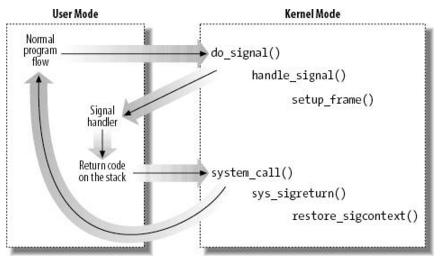

## Configurando as Flags dos Sinais

Após realizar os ajustes descritos acima a função **handle_signal** chama a função **signal_setup_done**, que por sua vez chama a função **signal_delivered**, indicando que um sinal foi entregue e verifica as flags relacionadas àquele sinal. Esta função apenas limpa a máscara de sinais salva anteriormente, pois a mesma será restaurada na syscall **sigreturn** e então verifica se a flag **SA_NODEFER** está ativa. Em caso negativo, o sinal que terá sua função de tratamento sendo executada ficará bloqueado enquanto executa a mesma, já se a flag não estiver ativa o próprio sinal pode interromper sua função de tratamento. Além disso a função **set_current_blocked** é chamada para atualizar o sinais bloqueados do processo atual e nesta função os sinais **SIGKILL** e **SIGSTOP** são sempre retirados de modo a fazer com que eles nunca possam ser bloqueados. 

```
  static void signal_delivered(struct ksignal *ksig, int stepping){
     sigset_t blocked;      
     clear_restore_sigmask();
     sigorsets(&blocked, &current->blocked, &ksig->ka.sa.sa_mask);
     if (!(ksig->ka.sa.sa_flags & SA_NODEFER))
        sigaddset(&blocked, ksig->sig);
     set_current_blocked(&blocked);
     tracehook_signal_handler(stepping);
  }
```

# Chamadas de Sistema

---
A tabela a seguir descreve as principais chamadas de função relacionadas a sinais. Algumas dessas chamadas já foram tratadas anteriormente, sendo outras descritas abaixo.

Syscall  | Descrição |
-------------------|------------------|
kill() | 	Envia um sinal para um processo |
tkill() |	Envia um sinal para uma thread|
tgkill() |	Envia um sinal para uma thread específica em um processo|
sigaction() |	Modifica a ação associada a um sinal|
signal() |	Similar a sigaction(), porém mais antigo|
sigpending() |	Verifica se existem sinais pendentes|
sigprocmask() |	Modifica o conjunto de sinais bloqueados|
sigsuspend() |	Espera por um sinal |

---


## sigaction

---
A sys_sigaction permite que usuários especifiquem uma ação para um sinal, que deverá ser executada ao invés da default action. Ela lida com três parâmetros: o número do sinal (sig); act, que define a nova ação; oact, que identifica a ação anterior relacionada com o sinal.

```
  SYSCALL_DEFINE3(sigaction, int, sig, const struct old_sigaction __user *, act, struct old_sigaction __user *, oact)
```

Ela primeiro checa se o endereço de act é válido, e então preenche sa_handler, sa_flags e sa_mask para uma nova variável do tipo k_sigaction correspondente aos campos do *act. A função então invoca do_sigaction para copiar essa nova variável em current->sig->action.

```c
{
  struct k_sigaction new_ka, old_ka; // a estrutura 
  //k_sigaction está relacionado a ação realziada por cada sinal
  // Uma é a antiga e outra a nova ação

	int ret;

  if (act) { // Checa se act é diferente de NULL, ou seja, válida
     old_sigset_t mask;
     if (!access_ok(act, sizeof(*act)) ||

        __get_user(new_ka.sa.sa_handler, &act->sa_handler) || // coloca uma  nova ação 
        // associada ao sinal, pode ser default (SIG_DFL), 
        // ignorarar (SIG_IGN) ou um ponteiro para função 

        __get_user(new_ka.sa.sa_restorer, &act->sa_restorer) ||


        __get_user(new_ka.sa.sa_flags, &act->sa_flags) || // sa_flags 
        // são as novas flagas associadas ao tratamento

        __get_user(mask, &act->sa_mask)) //a máscara dos sinais 
        // bloqueados durante a execução do tratador de sinais

            return -EFAULT; // retorna se o endereço de memória de algum 
            // argumento passado é inválido

      siginitset(&new_ka.sa.sa_mask, mask);
  } // Nova estrutura k_sigaction com os valores da nova ação

  	ret = do_sigaction(sig, act ? &new_ka : NULL, oact ? &old_ka : NULL);
    // Chamada a função do_sigaction 
    // Se o sinal associado for válido, verifica se a nova ação é valida
    // e coloca os seus dados na ação do sinal sig, ou seja,
    // o sinal sig agora tem uma nova ação de tratamento associada

	if (!ret && oact) {
		if (!access_ok(oact, sizeof(*oact)) ||
		    __put_user(old_ka.sa.sa_handler, &oact->sa_handler) ||
		    __put_user(old_ka.sa.sa_restorer, &oact->sa_restorer) ||
		    __put_user(old_ka.sa.sa_flags, &oact->sa_flags) ||
		    __put_user(old_ka.sa.sa_mask.sig[0], &oact->sa_mask))
			return -EFAULT;
	}
  // Salva os valores de mascara, tratamento e flags
  // da antiga ação (k_sigaction) na variável old_ka 

	return ret
}
```
* Pode ser encontrado em [signal.c](https://elixir.bootlin.com/linux/v5.4.2/source/kernel/signal.c#L4300)


## signal

---



A sys_signal varia seu comportamento em diferentes versões de Unix e Linux, essa syscall seta a disposição do sinal para o handler, o que pode ser SIG_IGN, SIG_DFL ou uma função de tratamento definida pelo usuário.

    Se a disposição é setada para SIG_IGN, então o sinal é ignorado
    Se a disposição é setada para SIG_DFL, então a ação default associada ao sinal ocorre.
    Se a disposição é setada para uma função, então primeiro a disposição é resetada para SIG_DFL, ou o sinal é bloqueado e então a função é chamada. Se a invocação desta função bloquear o sinal, então o sinal é desbloqueado ao retornar da função.

Os sinais SIGKILL e SIGSTOP não podem ser capturados ou ignorados.

```
  SYSCALL_DEFINE2(signal, int, sig, __sighandler_t, handler)
  {
     struct k_sigaction new_sa, old_sa;
     int ret;
     new_sa.sa.sa_handler = handler;
     new_sa.sa.sa_flags = SA_ONESHOT | SA_NOMASK;
     sigemptyset(&new_sa.sa.sa_mask);
     ret = do_sigaction(sig, &new_sa, &old_sa);
     return ret ? ret : (unsigned long)old_sa.sa.sa_handler;
  }
```
https://elixir.bootlin.com/linux/v5.4.2/source/kernel/signal.c

A sys_signal retorna o valor anterior da função de tratamento ou SIG_ERR. Caso ocorra um erro, então errno é setada para indicar a causa do erro.

Essa função problemas de portabilidade, e portanto deve ser evitada. Ao invés dela, deve ser utilizada a syscall sigaction.

## sigprocmask


---
A sys_sigprocmask permite ao processo modificar o conjunto de sinais bloqueados. Ela trabalha com três parâmetros: oldset é um ponteiro para o endereço na qual a máscara antiga será guardada; set é um ponteiro para o endereço na qual a nova máscara será armazenada; how é uma flag que pode conter três valores:

    SIG_BLOCK (a máscara *set especifica quais sinais serão bloqueados),
    SIG_UNBLOCK (a máscara *set especifica quais sinais serão removidos do vetor de sinais bloqueados)
    SIG_SETMASK (a máscara *set especifica a nova máscara de sinais bloqueados).

```
  SYSCALL_DEFINE3(sigprocmask, int, how, old_sigset_t __user *, nset, old_sigset_t __user *, oset)
  {
     old_sigset_t old_set, new_set;
     sigset_t new_blocked;
     old_set = current->blocked.sig[0];
     if (nset) {
        if (copy_from_user(&new_set, nset, sizeof(*nset)))
           return -EFAULT;
        new_blocked = current->blocked;
        switch (how) {
           case SIG_BLOCK:
              sigaddsetmask(&new_blocked, new_set);
              break;
           case SIG_UNBLOCK:
              sigdelsetmask(&new_blocked, new_set);
              break;
           case SIG_SETMASK:
              new_blocked.sig[0] = new_set;
              break;
           default:
              return -EINVAL;
         }
        set_current_blocked(&new_blocked);
     }
     if (oset) {
        if (copy_to_user(oset, &old_set, sizeof(*oset)))
           return -EFAULT;
     }
     return 0;
  }
```
https://elixir.bootlin.com/linux/v5.4.2/source/kernel/signal.c